## 1. Notebook Preparation

### Import dependencies

In [2]:
# General libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

# Classifier models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


### Initialize constants and paths

In [3]:
# Data
COMPETITION_NAME = 'playground-series-s4e1'
ORIGINAL_DATASET = 'shubhammeshram579/bank-customer-churn-prediction'

# Paths
MAIN_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

### Download the competition files

In [4]:
if not os.path.exists(MAIN_PATH):
    os.makedirs(MAIN_PATH, exist_ok=True)

    api = KaggleApi()
    api.authenticate()

    # Download the dataset to the local folder and unzip
    api.dataset_download_files(ORIGINAL_DATASET, path=MAIN_PATH, unzip=True)
    api.competition_download_files(COMPETITION_NAME, path=MAIN_PATH)

    zip_file_path = os.path.join(MAIN_PATH, f'{COMPETITION_NAME}.zip')

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(MAIN_PATH)

    os.remove(zip_file_path)

## 2. Load Data

In [5]:
original_data = pd.read_csv(f'{MAIN_PATH}/Churn_Modelling.csv')

df_train = pd.read_csv(f'{MAIN_PATH}/train.csv')
df_test = pd.read_csv(f'{MAIN_PATH}/test.csv')

submission = pd.read_csv(f'{MAIN_PATH}/sample_submission.csv')

## 3. Data Exploration & Upsizing Train Set

#### The dataset includes the following features:
- **Customer ID:** A unique identifier for each customer
- **Surname:** The customer's surname or last name
- **Credit Score:** A numerical value representing the customer's credit score
- **Geography:** The country where the customer resides (France, Spain or Germany)
- **Gender:** The customer's gender (Male or Female)
- **Age:** The customer's age.
- **Tenure:** The number of years the customer has been with the bank
- **Balance:** The customer's account balance
- **NumOfProducts:** The number of bank products the customer uses (e.g., savings account, credit card)
- **HasCrCard:** Whether the customer has a credit card (1 = yes, 0 = no)
- **IsActiveMember:** Whether the customer is an active member (1 = yes, 0 = no)
- **EstimatedSalary:** The estimated salary of the customer
- **Exited:** Whether the customer has churned (1 = yes, 0 = no)

### Exploration: Original Data

In [6]:
original_data.shape

(10002, 14)

In [7]:
original_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [8]:
original_data.duplicated().sum()

2

In [9]:
original_data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

### Exploration: Train Set

In [10]:
df_train.shape

(165034, 14)

In [11]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [12]:
df_train.duplicated().sum()

0

In [13]:
df_train.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Exploration: Test Set

In [14]:
df_test.shape

(110023, 13)

In [15]:
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [16]:
df_test.duplicated().sum()

0

In [17]:
df_test.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

### Exploration: Sample Submission


In [18]:
submission.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


### Upsizing Train Set
#### The provided train set from the competition is a synthetically-generated datasets that is based on the Churn Modelling dataset - also available on Kaggle. To improve model performance I am adding the original data to the competition data, as a larger training set helps the model extract information more reliably.

In [19]:
# Remove the ID / RowNumber column
df_train = df_train.drop("id", axis=1)
original_data = original_data.drop("RowNumber", axis=1)

In [20]:
# Add original data to the train set
df_train = pd.concat([df_train, original_data], axis=0)

In [21]:
df_train.shape


(175036, 13)

In [22]:
df_train.duplicated().sum()


2

In [23]:
df_train.isna().sum()


CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

#### There are some duplicated rows in the now upsized train set, as well as some rows with missing values:

- The duplicated rows will be dropped to keep each row unique.
- For the missing values, there are two options:
  - Impute the missing data
  - Drop the rows with missing data

####  Since there is a negligible number of rows that have missing values, I chose to drop these as well.

In [24]:
df_train = df_train.drop_duplicates().dropna()


In [25]:
df_train.duplicated().sum()


0

In [26]:
df_train.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Exploration: Categorical Features

In [27]:
categorical_data = df_train.select_dtypes(exclude=[np.number])

In [28]:
categorical_data.head()

,Surname,Geography,Gender
0,Okwudilichukwu,France,Male
1,Okwudiliolisa,France,Male
2,Hsueh,France,Male
3,Kao,France,Male
4,Chiemenam,Spain,Male


#### The surname feature is really not important to our model (and it's technically not categorical), so I'll drop it.

In [29]:
categorical_data = categorical_data.drop("Surname", axis=1)
categorical_data.head()

,Geography,Gender
0,France,Male
1,France,Male
2,France,Male
3,France,Male
4,Spain,Male


### Exploration: Numerical Features

In [30]:
numeric_data = df_train.select_dtypes(include=[np.number])


In [31]:
numeric_data.head()


,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [32]:
corr = numeric_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,1.000000,0.007299,0.003073,-0.002053,-0.008836,0.005178,-0.005875,-0.002693,0.003875,-0.009723
CreditScore,0.007299,1.000000,-0.008883,0.000950,0.005592,0.011605,-0.002607,0.015358,-0.000791,-0.027241
Age,0.003073,-0.008883,1.000000,-0.010786,0.063271,-0.097297,-0.012604,0.008960,-0.006685,0.336606
Tenure,-0.002053,0.000950,-0.010786,1.000000,-0.009642,0.007707,0.006412,-0.006868,0.001455,-0.019244
Balance,-0.008836,0.005592,0.063271,-0.009642,1.000000,-0.357267,-0.020303,-0.014139,0.004402,0.128389
NumOfProducts,0.005178,0.011605,-0.097297,0.007707,-0.357267,1.000000,0.005612,0.037827,-0.002422,-0.204509
HasCrCard,-0.005875,-0.002607,-0.012604,0.006412,-0.020303,0.005612,1.000000,-0.020682,0.004936,-0.021122
IsActiveMember,-0.002693,0.015358,0.008960,-0.006868,-0.014139,0.037827,-0.020682,1.000000,-0.008713,-0.207205
EstimatedSalary,0.003875,-0.000791,-0.006685,0.001455,0.004402,-0.002422,0.004936,-0.008713,1.000000,0.018598
Exited,-0.009723,-0.027241,0.336606,-0.019244,0.128389,-0.204509,-0.021122,-0.207205,0.018598,1.000000


#### The following 3 correclations are espsecially noticeable and seem to have a strong impact on the likelihood of a customer choosing to exit or remain with the service.

#### **Age - Exited** *↗ Positive Correlation*: As a customers age rises, so does the likelihood of them leaving the service.
#### **NumOfProducts - Exited** *↘ Negative Correlation*: If a customer owns more proudcts, it's less likely that they will leave.
#### **IsActiveMember - Exited** *↘ Negative Correlation*: If a customer is more active, it's less likely that they will leave.

## 4. Data Preprocessing

#### First, let's update the train and test dataset by dropping the surname as found in the exploration. And while we're at it, also drop the ID column from the test set, as we did for the train set.

In [33]:
df_train = df_train.drop('Surname', axis=1)

# Save the ID's of the test set just in case
test_ids = df_test['id']
df_test = df_test.drop(['Surname', 'id'], axis=1)


In [34]:
df_test.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15773898,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,15782418,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,15807120,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,15808905,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,15607314,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [35]:
df_train.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


#### Based on the feature description of the dataset, I will apply the following scalers / encoders to the listed features. This applies both to the train and the test set.

#### **Standard Scale:** <br>Transforms features to have a mean of 0 and a standard deviation of 1 by subtracting the mean and dividing by the standard deviation.
- CreditScore
- Age
- Balance
- EstimatedSalary


#### **Min-Max Scale:** <br> Rescales features to a specific range (usually 0 to 1) by subtracting the minimum and dividing by the range of values. 
- Tenure
- NumOfProducts
#### **Label Encode:** <br>Converts categorical labels into numerical values (0, 1, 2, etc.) to allow algorithms to process them as input.
- Geography
- Gender


In [36]:
# Unscaled Features
df_train_unscaled = df_train[['CustomerId', 'HasCrCard', 'IsActiveMember', 'Exited']]
df_test_unscaled = df_test[['CustomerId', 'HasCrCard', 'IsActiveMember']]

# Standard Scaled Features
df_train_standard = df_train[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']]
df_test_standard = df_test[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']]

# MinMax Scaled Features
df_train_minmax = df_train[['Tenure', 'NumOfProducts']]
df_test_minmax = df_test[['Tenure', 'NumOfProducts']]

# Label Encoded Features
df_train_label = df_train[['Geography', 'Gender']]
df_test_label = df_test[['Geography', 'Gender']]

### Standard Scaling

In [37]:
# Initialize Scaler
scaler = StandardScaler()

# Fit Scaler and transform train set
train_standard_scaled = scaler.fit_transform(df_train_standard)
# Transform test set
test_standard_scaled  = scaler.transform(df_test_standard)

# Check output
train_standard_scaled[0]

array([ 0.14646561, -0.5765412 , -0.89989476,  1.36942228])

In [38]:
# Convert scaled data back to DataFrame
df_train_standard_scaled = pd.DataFrame(train_standard_scaled, columns=df_train_standard.columns)
df_test_standard_scaled = pd.DataFrame(test_standard_scaled, columns=df_test_standard.columns)

In [39]:
df_train_standard_scaled.head()

,CreditScore,Age,Balance,EstimatedSalary
0,0.146466,-0.576541,-0.899895,1.369422
1,-0.358780,-0.576541,-0.899895,-1.227182
2,0.269696,0.203879,-0.899895,1.436661
3,-0.925640,-0.465053,1.463990,-0.537280
4,0.737972,-0.576541,-0.899895,-1.904830


### MinMax Scaling

In [40]:
# Initialize Scaler
scaler = MinMaxScaler()

# Fit Scaler and transform train set
train_minmax_scaled = scaler.fit_transform(df_train_minmax)
# Transform test set
test_minmax_scaled  = scaler.transform(df_test_minmax)

# Check output
train_minmax_scaled[0]

array([0.3       , 0.33333333])

In [41]:
# Convert scaled data back to a DataFrame
df_train_minmax_scaled = pd.DataFrame(train_minmax_scaled, columns=df_train_minmax.columns)
df_test_minmax_scaled = pd.DataFrame(test_minmax_scaled, columns=df_test_minmax.columns)

In [42]:
df_train_minmax_scaled.head()

,Tenure,NumOfProducts
0,0.3,0.333333
1,0.1,0.333333
2,1.0,0.333333
3,0.2,0.000000
4,0.5,0.333333


### Label Encoding

In [43]:
# Initialize Encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column (train)
for column in df_train_label.columns:
    df_train_label.loc[:, column] = label_encoder.fit_transform(df_train_label.loc[:, column])

for column in df_test_label.columns:
    df_test_label.loc[:, column] = label_encoder.fit_transform(df_test_label.loc[:, column])


In [44]:
# Make sure the dtypes are numerical
df_train_label['Geography'] = pd.to_numeric(df_train_label['Geography'])
df_train_label['Gender'] = pd.to_numeric(df_train_label['Gender'])

df_test_label['Geography'] = pd.to_numeric(df_test_label['Geography'])
df_test_label['Gender'] = pd.to_numeric(df_test_label['Gender'])

/tmp/ipykernel_43587/3251778588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_label['Geography'] = pd.to_numeric(df_train_label['Geography'])
/tmp/ipykernel_43587/3251778588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_label['Gender'] = pd.to_numeric(df_train_label['Gender'])
/tmp/ipykernel_43587/3251778588.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

### Concatenate all the scaled dataframes into one

In [45]:
df_train_to_concat = [df_train_unscaled, df_train_standard_scaled, df_train_minmax_scaled, df_train_label]

# Reset index before concatenating
for df in df_train_to_concat:
    df.reset_index(drop=True, inplace=True)

# Concatenate
df_train_scaled = pd.concat(df_train_to_concat, axis=1)

# Reorder columns
order = ['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
df_train_scaled = df_train_scaled[order]

df_train_scaled.head()


,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,0.146466,0,1,-0.576541,0.3,-0.899895,0.333333,1.0,0.0,1.369422,0
1,15749177,-0.358780,0,1,-0.576541,0.1,-0.899895,0.333333,1.0,1.0,-1.227182,0
2,15694510,0.269696,0,1,0.203879,1.0,-0.899895,0.333333,1.0,0.0,1.436661,0
3,15741417,-0.925640,0,1,-0.465053,0.2,1.463990,0.000000,1.0,1.0,-0.537280,0
4,15766172,0.737972,2,1,-0.576541,0.5,-0.899895,0.333333,1.0,1.0,-1.904830,0


In [46]:
df_test_to_concat = [df_test_unscaled, df_test_standard_scaled, df_test_minmax_scaled, df_test_label]

# Reset index before concatenating
for df in df_test_to_concat:
    df.reset_index(drop=True, inplace=True)

# Concatenate
df_test_scaled = pd.concat(df_test_to_concat, axis=1)
df_test_scaled.head()

# Reorder columns
order = ['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
df_test_scaled = df_test_scaled[order]

df_train_scaled.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,0.146466,0,1,-0.576541,0.3,-0.899895,0.333333,1.0,0.0,1.369422,0
1,15749177,-0.358780,0,1,-0.576541,0.1,-0.899895,0.333333,1.0,1.0,-1.227182,0
2,15694510,0.269696,0,1,0.203879,1.0,-0.899895,0.333333,1.0,0.0,1.436661,0
3,15741417,-0.925640,0,1,-0.465053,0.2,1.463990,0.000000,1.0,1.0,-0.537280,0
4,15766172,0.737972,2,1,-0.576541,0.5,-0.899895,0.333333,1.0,1.0,-1.904830,0


In [47]:
df_train_scaled.dtypes

CustomerId           int64
CreditScore        float64
Geography            int64
Gender               int64
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

## 5. Modelling

#### Now that the data is ready to go, I will attemtp to find the best performing model out of the following:
- LightGBM Model
- XGboost Model
- CatBoost Model

### Data Splitting

In [48]:
X_train = df_train_scaled.drop('Exited', axis=1)
y_train = df_train_scaled['Exited']
X_test = df_test_scaled

### LGBM Model

In [49]:
lgbm = LGBMClassifier(**{  'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : 42,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'learning_rate'       : 0.05,
                           'max_depth'           : 8,
                           'n_estimators'        : 1000,
                           'num_leaves'          : 140,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1,
                          })

### XBG Model

In [50]:
xgb  = XGBClassifier(**{  'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : 42,
                          'colsample_bytree'      : 0.25,
                          'learning_rate'         : 0.07,
                          'max_depth'             : 8,
                          'n_estimators'          : 800,
                          'reg_alpha'             : 0.09,
                          'reg_lambda'            : 0.70,
                          'min_child_weight'      : 22,
                          'verbosity'             : 0,
                         })

### CatBoost Model

In [51]:
cat  = CatBoostClassifier(**{
                         'iterations'            : 10000,
                         'objective'             : 'Logloss',
                         'eval_metric'           : "AUC",
                         'early_stopping_rounds' : 1000,
                         'bagging_temperature'   : 0.1,
                         'colsample_bylevel'     : 0.88,
                         'iterations'            : 1000,
                         'learning_rate'         : 0.065,
                         'max_depth'             : 7,
                         'l2_leaf_reg'           : 1,
                         'min_data_in_leaf'      : 25,
                         'random_strength'       : 0.1,
                         'max_bin'               : 100,
                         'verbose'               : 0,
                        })

### Applying a Voting Classifier
#### It aggregates the predictions of each base classifier and predicts the class that receives the most votes (or the highest probability, depending on the strategy used) from the individual classifiers.

In [51]:
vote = VotingClassifier(estimators=[('lgbm', lgbm),
                                    ('xgb', xgb),
                                    ('cat', cat)],
                        voting='soft',
                        weights=[2, 1, 1]
                        )

### Set up repeated stratified k-fold Cross-Validation process and lists to store the results

In [52]:
# List to store AUC (Area Under the ROC Curve) obtained from each fold in the cross-val
aucs = []

# List to store predictions
predictions = []

# Cross Validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)


### Fit and run the model

In [241]:
for train_index, test_index in kf.split(X_train, y_train):
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model
    vote.fit(X_train_kf, y_train_kf)

    # Predict probabilities for validation set
    y_pred_val = vote.predict_proba(X_val_kf)[:, 1]

    # Calculate AUC for validation set
    auc_val = roc_auc_score(y_val_kf, y_pred_val)
    aucs.append(auc_val)

    # Predict probabilities for test set (df_test)
    y_pred_test = vote.predict_proba(X_test)[:, 1]
    predictions.append(y_pred_test)

### Interpreting the AUC Scores

In [251]:
max_auc = 0
max_index = 0
for i, score in enumerate(aucs):
    print(f"AUC for validation set {i}: {score}")
    if score > max_auc:
        max_auc, max_index = score, i


print('\n', f'The highest score of {max_auc} was achieved on validation set {i}.')

AUC for validation set 0: 0.8885280782865606
AUC for validation set 1: 0.8880361097059754
AUC for validation set 2: 0.8863708428139061
AUC for validation set 3: 0.8887927098040174
AUC for validation set 4: 0.887369014560498
AUC for validation set 5: 0.8884002380862965
AUC for validation set 6: 0.890319279093469
AUC for validation set 7: 0.888793557333519
AUC for validation set 8: 0.8833125203603042
AUC for validation set 9: 0.888251968835527
AUC for validation set 10: 0.8844197202615853
AUC for validation set 11: 0.8878834314911386
AUC for validation set 12: 0.8862994249811174
AUC for validation set 13: 0.8882842557903217
AUC for validation set 14: 0.8917177496702374

 The highest score of 0.8917177496702374 was achieved on validation set 14.


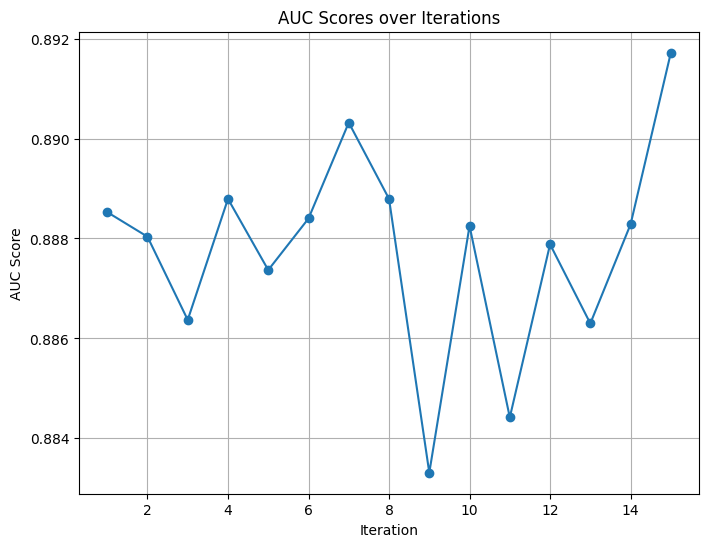

In [256]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(aucs) + 1), aucs, marker='o', linestyle='-')
plt.title('AUC Scores over Iterations')
plt.xlabel('Iteration')
plt.ylabel('AUC Score')
plt.grid(True)
plt.show()

### Turn Predictions into Dataframe

In [264]:
avg_submission = pd.DataFrame(predictions).mean(axis=0)

submission["Exited"] = avg_submission
submission.head()


,id,Exited
0,165034,0.029928
1,165035,0.835176
2,165036,0.020069
3,165037,0.213110
4,165038,0.351489


## 6. Submission

In [268]:
# Make submissions folder
submission_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'submissions'))
os.makedirs((submission_path), exist_ok=True)


In [269]:
# Save submission to CSV
submission.to_csv(os.path.join(submission_path, 'submission.csv'), index=False)

## 7. Optimization attempts

### Grid Search (Cancelled after runtime of over 350min)

In [ ]:
"""
Original LGBM:

lgbm = LGBMClassifier(**{  'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : 42,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'learning_rate'       : 0.05,
                           'max_depth'           : 8,
                           'n_estimators'        : 1000,
                           'num_leaves'          : 140,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1,
                          })
"""

In [ ]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [100, 140, 180],
    'max_depth': [6, 8, 10],
}

lgbm = LGBMClassifier(**{  'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : 42,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'n_estimators'        : 1000,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1,
                          })

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_


In [ ]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

### OPTUNA

In [52]:
import optuna

/home/jarisfenner/.pyenv/versions/3.10.6/envs/kaggle_comp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### LGBM

In [60]:
def objective(trial):
    params = {  'objective'           : 'binary',
                'boosting_type'       : 'gbdt',
                'metric'              : 'auc',
                'random_state'        : 42,
                'colsample_bytree'    : 0.56,
                'subsample'           : 0.35,
                'n_estimators'        : 1000,
                'reg_alpha'           : 0.14,
                'reg_lambda'          : 0.85,
                'verbosity'           : -1,
                'n_jobs'              : -1,
                'learning_rate'       : trial.suggest_float('learning_rate', 0.01, 0.5),
                'num_leaves'          : trial.suggest_int('num_leaves', 10, 150),
                'max_depth'           : trial.suggest_int('max_depth', 3, 15)
                }

    model = LGBMClassifier(**params)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    return cv_scores.mean()

In [61]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-01-09 12:46:04,128] A new study created in memory with name: no-name-f5fca59e-2caf-4d46-8fe8-c0dfdc62aa72


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-09 12:50:07,760] Trial 0 finished with value: 0.8858056128367561 and parameters: {'learning_rate': 0.04236265146451868, 'num_leaves': 95, 'max_depth': 12}. Best is trial 0 with value: 0.8858056128367561.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-09 12:54:43,631] Trial 1 finished with value: 0.8577578649382861 and parameters: {'learning_rate': 0.37172034511657714, 'num_leaves': 126, 'max_depth': 15}. Best is trial 0 with value: 0.8858056128367561.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 12:56:21,621] Trial 2 finished with value: 0.8881855518787742 and parameters: {'learning_rate': 0.07518955611785419, 'num_leaves': 43, 'max_depth': 3}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:00:29,626] Trial 3 finished with value: 0.883834526957323 and parameters: {'learning_rate': 0.06003001630967356, 'num_leaves': 132, 'max_depth': 7}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:03:00,321] Trial 4 finished with value: 0.8700230742566161 and parameters: {'learning_rate': 0.3465321365918949, 'num_leaves': 139, 'max_depth': 5}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:04:46,856] Trial 5 finished with value: 0.8830857909369193 and parameters: {'learning_rate': 0.4032626847895647, 'num_leaves': 109, 'max_depth': 3}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-09 13:08:01,898] Trial 6 finished with value: 0.8754001355176951 and parameters: {'learning_rate': 0.11961375807688321, 'num_leaves': 108, 'max_depth': 13}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-09 13:10:18,821] Trial 7 finished with value: 0.8736094532358974 and parameters: {'learning_rate': 0.26096821746603605, 'num_leaves': 34, 'max_depth': 8}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-09 13:14:38,239] Trial 8 finished with value: 0.8635796922523963 and parameters: {'learning_rate': 0.24525755873878446, 'num_leaves': 118, 'max_depth': 13}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:16:14,442] Trial 9 finished with value: 0.8870214876967014 and parameters: {'learning_rate': 0.1747984427259587, 'num_leaves': 52, 'max_depth': 3}. Best is trial 2 with value: 0.8881855518787742.
[I 2024-01-09 13:17:23,065] Trial 10 finished with value: 0.8859804922583702 and parameters: {'learning_rate': 0.15987539391293512, 'num_leaves': 12, 'max_depth': 10}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:18:36,968] Trial 11 finished with value: 0.8870488171758466 and parameters: {'learning_rate': 0.17320975746805026, 'num_leaves': 57, 'max_depth': 3}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:20:27,840] Trial 12 finished with value: 0.8612007732156771 and parameters: {'learning_rate': 0.4929439197601233, 'num_leaves': 59, 'max_depth': 5}. Best is trial 2 with value: 0.8881855518787742.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:22:34,943] Trial 13 finished with value: 0.8884969172710387 and parameters: {'learning_rate': 0.01496754835107375, 'num_leaves': 73, 'max_depth': 5}. Best is trial 13 with value: 0.8884969172710387.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:25:15,901] Trial 14 finished with value: 0.8841555314817885 and parameters: {'learning_rate': 0.08029967961981618, 'num_leaves': 80, 'max_depth': 6}. Best is trial 13 with value: 0.8884969172710387.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:26:26,169] Trial 15 finished with value: 0.8883510224740471 and parameters: {'learning_rate': 0.01093885646343592, 'num_leaves': 79, 'max_depth': 5}. Best is trial 13 with value: 0.8884969172710387.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:27:08,314] Trial 16 finished with value: 0.8881060019626696 and parameters: {'learning_rate': 0.017910643784964653, 'num_leaves': 79, 'max_depth': 9}. Best is trial 13 with value: 0.8884969172710387.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:27:40,053] Trial 17 finished with value: 0.8760203510346147 and parameters: {'learning_rate': 0.25194088724775465, 'num_leaves': 71, 'max_depth': 5}. Best is trial 13 with value: 0.8884969172710387.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-09 13:29:19,078] Trial 18 finished with value: 0.876309192339607 and parameters: {'learning_rate': 0.12410371867233755, 'num_leaves': 98, 'max_depth': 7}. Best is trial 13 with value: 0.8884969172710387.
[I 2024-01-09 13:29:50,437] Trial 19 finished with value: 0.8885196095338833 and parameters: {'learning_rate': 0.01114637618097003, 'num_leaves': 29, 'max_depth': 10}. Best is trial 19 with value: 0.8885196095338833.


In [62]:
print('Best Params:', study.best_params)
print('Best Score:', study.best_value)

Best Params: {'learning_rate': 0.01114637618097003, 'num_leaves': 29, 'max_depth': 10}
Best Score: 0.8885196095338833


#### XGB

In [63]:
def objective2(trial):
    params = {  'objective'             : 'binary:logistic',
                'eval_metric'           : 'auc',
                'random_state'          : 42,
                'colsample_bytree'      : 0.25,
                'reg_alpha'             : 0.09,
                'reg_lambda'            : 0.70,
                'min_child_weight'      : 22,
                'verbosity'             : 0,
                'n_jobs'                : -1,
                'learning_rate'         : trial.suggest_float('learning_rate', 0.01, 0.5),
                'n_estimators'          : trial.suggest_int('n_estimators', 800, 1500),
                'max_depth'             : trial.suggest_int('max_depth', 3, 15)
                }

    model = XGBClassifier(**params)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    return cv_scores.mean()

In [64]:
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective2, n_trials=20)

[I 2024-01-09 13:29:50,517] A new study created in memory with name: no-name-766bce8b-0cf4-43f9-82fa-200547e76890
[I 2024-01-09 13:30:19,398] Trial 0 finished with value: 0.8797702574132584 and parameters: {'learning_rate': 0.14635050146762987, 'n_estimators': 1377, 'max_depth': 8}. Best is trial 0 with value: 0.8797702574132584.
[I 2024-01-09 13:30:44,261] Trial 1 finished with value: 0.8740028375949195 and parameters: {'learning_rate': 0.45191403398054486, 'n_estimators': 1385, 'max_depth': 6}. Best is trial 0 with value: 0.8797702574132584.
[I 2024-01-09 13:31:08,290] Trial 2 finished with value: 0.8666125065958723 and parameters: {'learning_rate': 0.4437850998633399, 'n_estimators': 949, 'max_depth': 10}. Best is trial 0 with value: 0.8797702574132584.
[I 2024-01-09 13:31:42,524] Trial 3 finished with value: 0.8604297292074335 and parameters: {'learning_rate': 0.3897638005680548, 'n_estimators': 1178, 'max_depth': 13}. Best is trial 0 with value: 0.8797702574132584.
[I 2024-01-09 1

In [65]:
print('Best Params:', study2.best_params)
print('Best Score:', study2.best_value)

Best Params: {'learning_rate': 0.11688653474788521, 'n_estimators': 893, 'max_depth': 4}
Best Score: 0.8867230908451397


#### CatBoost

In [81]:
def objective3(trial):
    params = {  'objective'             : 'Logloss',
                'eval_metric'           : 'AUC',
                'early_stopping_rounds' : 1000,
                'bagging_temperature'   : 0.1,
                'colsample_bylevel'     : 0.88,
                'l2_leaf_reg'           : 1,
                'min_data_in_leaf'      : 25,
                'random_strength'       : 0.1,
                'max_bin'               : 100,
                'verbose'               : 0,
                'thread_count'          : -1,
                'learning_rate'         : trial.suggest_float('learning_rate', 0.01, 0.2),
                'iterations'            : trial.suggest_int('iterations', 800, 1100),
                'max_depth'             : trial.suggest_int('max_depth', 3, 10)
                }

    model = CatBoostClassifier(**params)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    return cv_scores.mean()

In [82]:
study3 = optuna.create_study(direction='maximize')
study3.optimize(objective3, n_trials=20)

[I 2024-01-09 14:05:51,987] A new study created in memory with name: no-name-a4eb0edc-4839-4ab7-a3ac-64a9cf23ae7f
[I 2024-01-09 14:07:09,777] Trial 0 finished with value: 0.8842104711683193 and parameters: {'learning_rate': 0.14563167687518286, 'iterations': 887, 'max_depth': 6}. Best is trial 0 with value: 0.8842104711683193.
[I 2024-01-09 14:08:27,023] Trial 1 finished with value: 0.8880245331991472 and parameters: {'learning_rate': 0.06366152589438624, 'iterations': 1016, 'max_depth': 5}. Best is trial 1 with value: 0.8880245331991472.
[I 2024-01-09 14:10:22,778] Trial 2 finished with value: 0.8801231496999874 and parameters: {'learning_rate': 0.07419260281394204, 'iterations': 893, 'max_depth': 9}. Best is trial 1 with value: 0.8880245331991472.
[I 2024-01-09 14:11:50,750] Trial 3 finished with value: 0.8807484033172178 and parameters: {'learning_rate': 0.1307383731914684, 'iterations': 1015, 'max_depth': 7}. Best is trial 1 with value: 0.8880245331991472.
[I 2024-01-09 14:12:55,58

In [83]:
print('Best Params:', study3.best_params)
print('Best Score:', study3.best_value)

Best Params: {'learning_rate': 0.03762055689265273, 'iterations': 952, 'max_depth': 4}
Best Score: 0.8884337818177573


## 8. Remodelling with optimized Params

### LGBM Model

In [84]:
lgbm = LGBMClassifier(**{  'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : 'auc',
                           'random_state'        : 42,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'n_estimators'        : 1000,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1,
                           'n_jobs'              : -1,
                           'learning_rate'       : 0.01114637618097003,
                           'num_leaves'          : 29,
                           'max_depth'           : 10
                           })


### XBG Model

In [86]:
xgb  = XGBClassifier(**{  'objective'             : 'binary:logistic',
                          'eval_metric'           : 'auc',
                          'random_state'          : 42,
                          'colsample_bytree'      : 0.25,
                          'reg_alpha'             : 0.09,
                          'reg_lambda'            : 0.70,
                          'min_child_weight'      : 22,
                          'verbosity'             : 0,
                          'n_jobs'                : -1,
                          'learning_rate'         : 0.11688653474788521,
                          'n_estimators'          : 893,
                          'max_depth'             : 4
                          })


### CatBoost Model

In [87]:
cat  = CatBoostClassifier(**{  'objective'             : 'Logloss',
                               'eval_metric'           : 'AUC',
                               'early_stopping_rounds' : 1000,
                               'bagging_temperature'   : 0.1,
                               'colsample_bylevel'     : 0.88,
                               'l2_leaf_reg'           : 1,
                               'min_data_in_leaf'      : 25,
                               'random_strength'       : 0.1,
                               'max_bin'               : 100,
                               'verbose'               : 0,
                               'thread_count'          : -1,
                               'learning_rate'         : 0.03762055689265273,
                               'iterations'            : 952,
                               'max_depth'             : 4
                               })


### Applying a Voting Classifier
#### It aggregates the predictions of each base classifier and predicts the class that receives the most votes (or the highest probability, depending on the strategy used) from the individual classifiers.

In [88]:
vote = VotingClassifier(estimators=[('lgbm', lgbm),
                                    ('xgb', xgb),
                                    ('cat', cat)],
                        voting='soft',
                        weights=[2, 1, 1]
                        )

### Set up repeated stratified k-fold Cross-Validation process and lists to store the results

In [89]:
# List to store AUC (Area Under the ROC Curve) obtained from each fold in the cross-val
aucs2 = []

# List to store predictions
predictions2 = []

# Cross Validation
kf2 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)


### Fit and run the model

In [90]:
for train_index, test_index in kf2.split(X_train, y_train):
    X_train_kf2, X_val_kf2 = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf2, y_val_kf2 = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model
    vote.fit(X_train_kf2, y_train_kf2)

    # Predict probabilities for validation set
    y_pred_val = vote.predict_proba(X_val_kf2)[:, 1]

    # Calculate AUC for validation set
    auc_val = roc_auc_score(y_val_kf2, y_pred_val)
    aucs2.append(auc_val)

    # Predict probabilities for test set (df_test)
    y_pred_test = vote.predict_proba(X_test)[:, 1]
    predictions2.append(y_pred_test)

### Interpreting the AUC Scores

In [92]:
max_auc2 = 0
max_index2 = 0
for i, score in enumerate(aucs2):
    print(f"AUC for validation set {i}: {score}")
    if score > max_auc2:
        max_auc2, max_index2 = score, i


print('\n', f'The highest score of {max_auc2} was achieved on validation set {i}.')

AUC for validation set 0: 0.8895880360876584
AUC for validation set 1: 0.8892038173081348
AUC for validation set 2: 0.8876212819615623
AUC for validation set 3: 0.8901087712503571
AUC for validation set 4: 0.8887133335222394
AUC for validation set 5: 0.8893646458409994
AUC for validation set 6: 0.8917147840424171
AUC for validation set 7: 0.8902161282532199
AUC for validation set 8: 0.8843942766420949
AUC for validation set 9: 0.889682187116799
AUC for validation set 10: 0.8853873812841996
AUC for validation set 11: 0.8897752900730523
AUC for validation set 12: 0.8874196091323272
AUC for validation set 13: 0.889810210612159
AUC for validation set 14: 0.8928762073719115

 The highest score of 0.8928762073719115 was achieved on validation set 14.


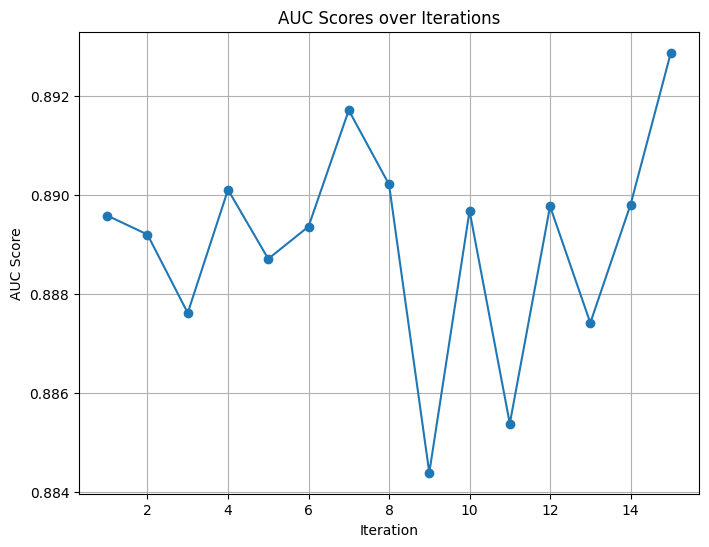

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(aucs2) + 1), aucs2, marker='o', linestyle='-')
plt.title('AUC Scores over Iterations')
plt.xlabel('Iteration')
plt.ylabel('AUC Score')
plt.grid(True)
plt.show()

### Turn Predictions into Dataframe

In [96]:
avg_submission2 = pd.DataFrame(predictions2).mean(axis=0)

submission2 = pd.read_csv(f'{MAIN_PATH}/sample_submission.csv')

submission2["Exited"] = avg_submission2
submission2.head()


,id,Exited
0,165034,0.025893
1,165035,0.816201
2,165036,0.025527
3,165037,0.226116
4,165038,0.359537


### Re-Submission

In [97]:
# Make submissions folder
submission_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'submissions'))

In [98]:
# Save submission to CSV
submission2.to_csv(os.path.join(submission_path, 'submission2.csv'), index=False)